In [1]:
import sys
sys.path.insert(0, "..")

import torch
import torch.nn as nn
from src.utils.provider import Provider, DictProvider
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from torchinfo import summary

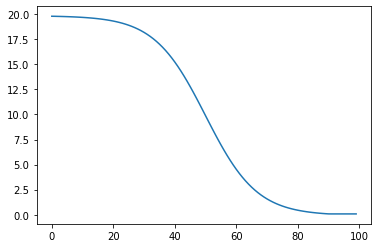

In [2]:
def create_tanh_decay(
    max: float,
    min: float,
    width: float,
    alpha: float = 3.0,
    rising=False,
):
    """
    Create a tanh decay function that accepts an x-value>=0 and provides corresponding y-value between [min, max].
    """
    h = (max - min) / 2.0
    w = width / 2.0

    def _f(x: np.ndarray):
        a = 1.0 - np.tanh(alpha * (x - w) / w)
        if rising:
            a = 2.0 - a
        return np.maximum(a * h - min, min)

    return _f


f = create_tanh_decay(max=20.0, min=0.08, width=100)
x = np.arange(100)
y = f(x)

plt.plot(x, y)


In [3]:
f = create_tanh_decay(max=20.0, min=0.08, width=100, inverse=True)
x = np.arange(100)
y = f(x)

plt.plot(x, y)

TypeError: create_tanh_decay() got an unexpected keyword argument 'inverse'

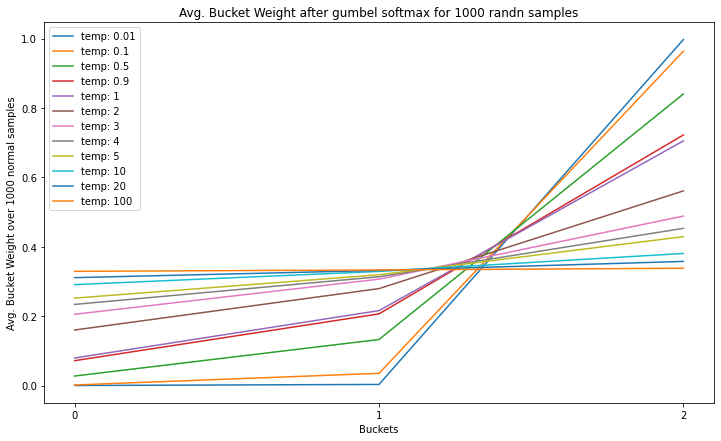

In [ ]:
# show gumbel softmax plots

n = 3
q = 1000
temp = [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

plt.figure(figsize=(12, 7))

for t in temp:
    data = F.gumbel_softmax(torch.randn((q, n)), tau=np.array(t)).sort(dim=-1).values.mean(dim=0)
    plt.plot(np.arange(n), data)

plt.legend([f'temp: {t}' for t in temp])
plt.title(f"Avg. Bucket Weight after gumbel softmax for {q} randn samples")
plt.xlabel("Buckets")
plt.ylabel(f"Avg. Bucket Weight over {q} normal samples")
plt.xticks(list(range(n)))
plt.show()
# plt.yscale('log')

# Anything above temp 20 is useless
# use tanh decay from temp 20 -> 0.1

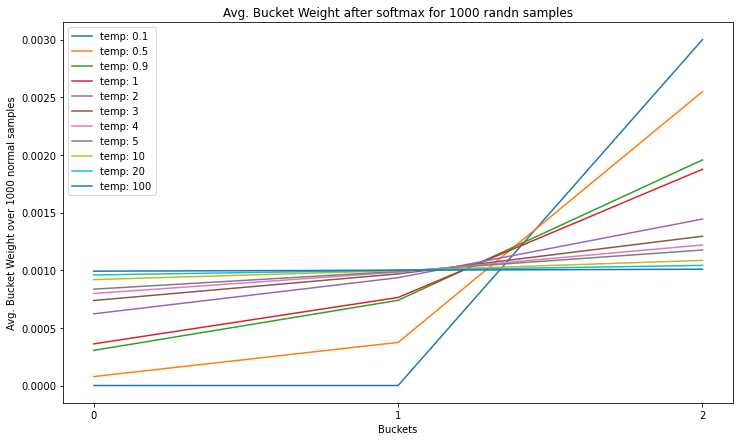

In [4]:
# show softmax temperature plots

def softmax_temperature(x, temp=1.0, dim=0):
    return F.softmax(x/temp, dim=dim)

n = 3
q = 1000
temp = [0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

plt.figure(figsize=(12, 7))

for t in temp:
    data = softmax_temperature(torch.randn((q, n)), temp=np.array(t)).sort(dim=-1).values.mean(dim=0)
    plt.plot(np.arange(n), data)

plt.legend([f'temp: {t}' for t in temp])
plt.title(f"Avg. Bucket Weight after softmax for {q} randn samples")
plt.xlabel("Buckets")
plt.ylabel(f"Avg. Bucket Weight over {q} normal samples")
plt.xticks(list(range(n)))
plt.show()
# plt.yscale('log')

# use tanh rising from temp 20 -> 0.1

## Boxplots for gumbel softmax

See: https://stackoverflow.com/a/56498949/10027894

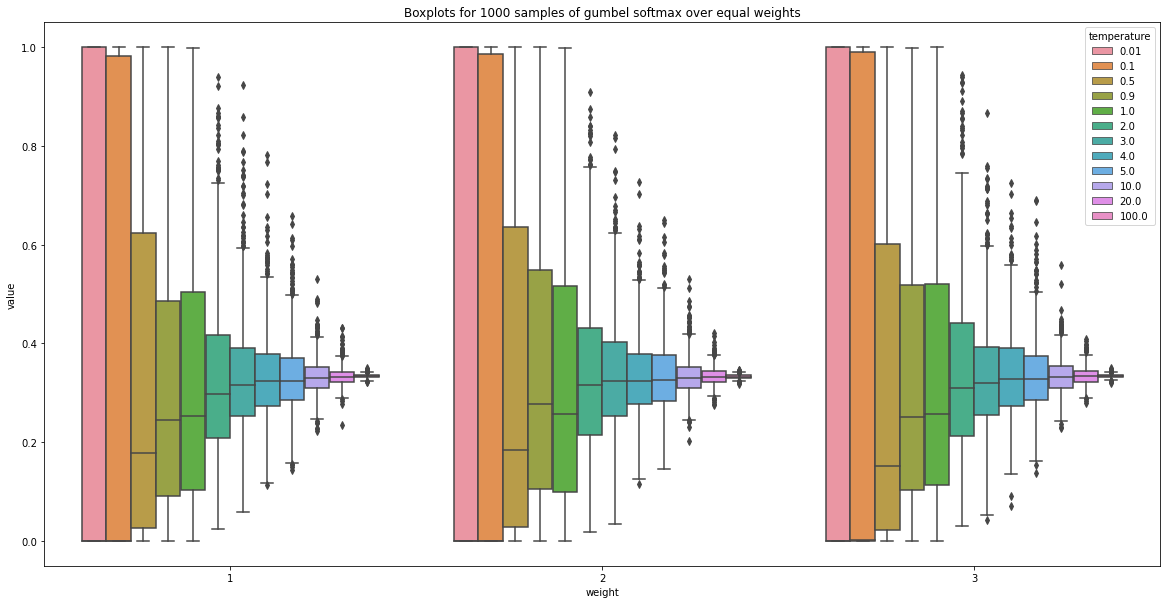

In [34]:
# show gumbel softmax plots

n = 3
q = 1000
temp = [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

data = []
for t in temp:
    d = F.gumbel_softmax(torch.ones((q, n)), tau=np.array(t))
    t = torch.as_tensor(t).expand((q, 1))
    d = torch.cat([t, d], dim=1)
    data.append(d)

data = torch.cat(data, dim=0)
data = pd.DataFrame(data, columns=['temperature'] + list(range(1, n+1)))

# plot data
plot = data.melt(id_vars='temperature', value_name="value", var_name='weight')

plt.figure(figsize=[20,10])
plt.title(f"Boxplots for {q} samples of gumbel softmax over equal weights")
p = sns.boxplot(x='weight', y='value', data=plot, hue='temperature')
plt.show()

In [39]:
# show gumbel softmax plots

n = 3
q = 1000
temp = [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

data = []
for t in temp:
    d = F.gumbel_softmax(torch.rand((q, n)), tau=np.array(t))
    t = torch.as_tensor(t).expand((q, 1))
    d = torch.cat([t, d], dim=1)
    data.append(d)

data = torch.cat(data, dim=0)
data = pd.DataFrame(data, columns=['temperature'] + list(range(1, n+1)))

# plot data
plot = data.melt(id_vars='temperature', value_name="value", var_name='weight')

plt.figure(figsize=[20,10])
plt.title(f"Boxplots for {q} samples of gumbel softmax over uniform random weights")
p = sns.boxplot(x='weight', y='value', data=plot, hue='temperature')
plt.show()

## Boxplots for temperature softmax

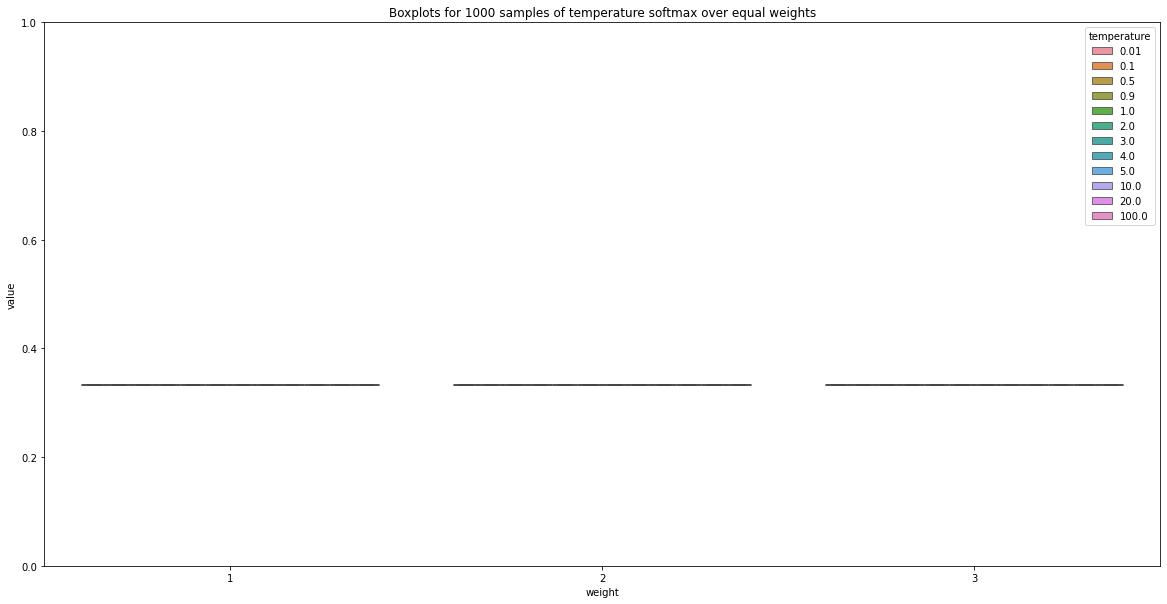

In [36]:
# show softmax plots

n = 3
q = 1000
temp = [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

data = []
for t in temp:
    d = softmax_temperature(torch.ones((q, n)), temp=np.array(t), dim=1)
    t = torch.as_tensor(t).expand((q, 1))
    d = torch.cat([t, d], dim=1)
    data.append(d)

data = torch.cat(data, dim=0)
data = pd.DataFrame(data, columns=['temperature'] + list(range(1, n+1)))

# plot data
plot = data.melt(id_vars='temperature', value_name="value", var_name='weight')

plt.figure(figsize=[20,10])
plt.title(f"Boxplots for {q} samples of temperature softmax over equal weights")
plt.ylim([0,1])
p = sns.boxplot(x='weight', y='value', data=plot, hue='temperature')
plt.show()

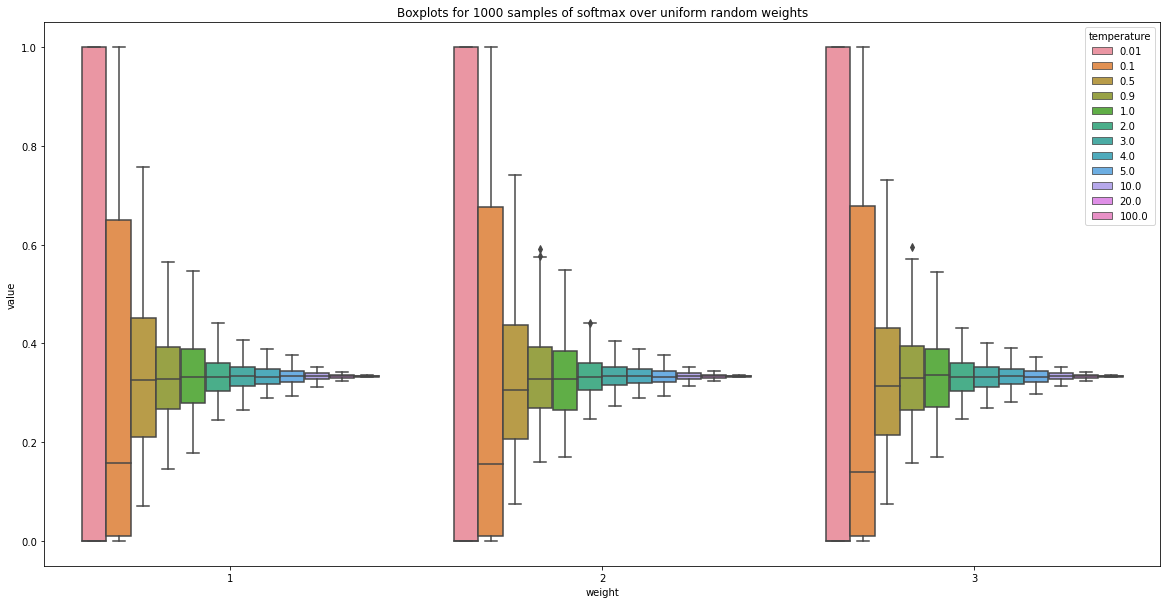

In [38]:
# show softmax plots

n = 3
q = 1000
temp = [0.01, 0.1, 0.5, 0.9, 1, 2, 3, 4, 5, 10, 20, 100]

data = []
for t in temp:
    d = softmax_temperature(torch.rand((q, n)), temp=np.array(t), dim=1)
    t = torch.as_tensor(t).expand((q, 1))
    d = torch.cat([t, d], dim=1)
    data.append(d)

data = torch.cat(data, dim=0)
data = pd.DataFrame(data, columns=['temperature'] + list(range(1, n+1)))

# plot data
plot = data.melt(id_vars='temperature', value_name="value", var_name='weight')

plt.figure(figsize=[20,10])
plt.title(f"Boxplots for {q} samples of softmax over uniform random weights")
# plt.ylim([0,1])
p = sns.boxplot(x='weight', y='value', data=plot, hue='temperature')
plt.show()